# 1. Import The Libraries

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

# 2. Load The Data

In [3]:
df = pd.read_csv('Credit Card Customer Data.csv')
features = df.drop(['Sl_No', 'Customer Key'], axis=1)
print(f"Shape of features: {features.shape}")
df.head()

Shape of features: (660, 5)


,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


# 3. Scaling The Features

In [4]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# 4. Find Optimal Epsilon (eos) Parameter

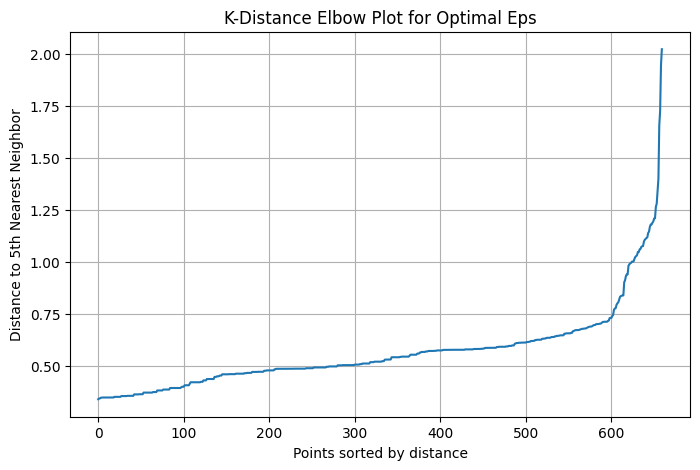

Observe the 'knee' where the curve bends sharply upward.
In this dataset, the elbow is around eps ≈ 1.2 (sharp rise starts near index 650, distance ~1.2)


In [5]:
# Find Optimal Epsilon (eps) with Elbow Plot (min_samples=5 as reference)
neigh = NearestNeighbors(n_neighbors=5)
neigh.fit(X_scaled)
distances, _ = neigh.kneighbors(X_scaled)
sorted_dist = np.sort(distances[:, 4], axis=0)

plt.figure(figsize=(8,5))
plt.plot(sorted_dist)
plt.title('K-Distance Elbow Plot for Optimal Eps')
plt.xlabel('Points sorted by distance')
plt.ylabel('Distance to 5th Nearest Neighbor')
plt.grid(True)
plt.show()

print("Observe the 'knee' where the curve bends sharply upward.")
print("In this dataset, the elbow is around eps ≈ 1.2 (sharp rise starts near index 650, distance ~1.2)")

# 5. Test Different DBSCAN Parameters

In [6]:
print("\n" + "="*60)
print("TESTING DIFFERENT PARAMETERS")
print("="*60)
# Test Different DBSCAN Parameters (grid search for good silhouette)
print("Testing combinations...\n")

eps_values = np.round(np.arange(0.8, 1.8, 0.1), 2)
min_samples_values = range(4, 8)

best_score = -1
best_eps = None
best_min_samples = None
best_clusters = None
best_noise = None

for eps in eps_values:
    for min_s in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=min_s)
        labels = db.fit_predict(X_scaled)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        if n_clusters > 1:
            sil = silhouette_score(X_scaled[labels != -1], labels[labels != -1])
            print(f'eps={eps}, min_samples={min_s} → clusters={n_clusters}, noise={n_noise}, silhouette={sil:.4f}')
            if sil > best_score:
                best_score = sil
                best_eps = eps
                best_min_samples = min_s
                best_clusters = n_clusters
                best_noise = n_noise

print(f'\nBest parameters found:')
print(f'eps = {best_eps}, min_samples = {best_min_samples}')
print(f'Clusters = {best_clusters}, Noise points = {best_noise}, Silhouette = {best_score:.4f}')


TESTING DIFFERENT PARAMETERS
Testing combinations...

eps=0.8, min_samples=4 → clusters=4, noise=28, silhouette=0.4999
eps=0.8, min_samples=5 → clusters=2, noise=44, silhouette=0.5445
eps=0.8, min_samples=6 → clusters=2, noise=48, silhouette=0.5315
eps=0.9, min_samples=4 → clusters=3, noise=22, silhouette=0.4911
eps=0.9, min_samples=5 → clusters=3, noise=27, silhouette=0.4940
eps=0.9, min_samples=6 → clusters=3, noise=31, silhouette=0.4810
eps=0.9, min_samples=7 → clusters=2, noise=42, silhouette=0.5560
eps=1.0, min_samples=4 → clusters=2, noise=15, silhouette=0.5716
eps=1.0, min_samples=5 → clusters=2, noise=18, silhouette=0.5680
eps=1.0, min_samples=6 → clusters=2, noise=22, silhouette=0.5696
eps=1.0, min_samples=7 → clusters=2, noise=30, silhouette=0.5563
eps=1.1, min_samples=4 → clusters=2, noise=5, silhouette=0.5698
eps=1.1, min_samples=5 → clusters=2, noise=6, silhouette=0.5712
eps=1.1, min_samples=6 → clusters=2, noise=14, silhouette=0.5713
eps=1.1, min_samples=7 → clusters=2, 

# 6. Build the Model ( DBSCAN )

In [7]:
print("\n" + "="*60)
print("BUILDING FINAL MODEL")
print("="*60)

# Build the final model with optimal parameters
db_opt = DBSCAN(eps=1.2, min_samples=4)  # From the grid search above
labels = db_opt.fit_predict(X_scaled)

n_clusters_final = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_final = list(labels).count(-1)

print(f'Final DBSCAN model:')
print(f'Number of clusters (suitable k): {n_clusters_final}')
print(f'Number of noise points: {n_noise_final}')


BUILDING FINAL MODEL
Final DBSCAN model:
Number of clusters (suitable k): 2
Number of noise points: 3


# 7. Evaluation ( DBSCAN )

In [8]:
print("\n" + "="*60)
print("MODEL EVALUATION")
print("="*60)

# Evaluate with Silhouette Score (excluding noise points)
if n_clusters_final > 1:
    score = silhouette_score(X_scaled[labels != -1], labels[labels != -1])
    print(f'Final Silhouette Score: {score:.4f}')
else:
    print('Not enough clusters for silhouette score')


MODEL EVALUATION
Final Silhouette Score: 0.5740


# 8. Visualization DBSCAN

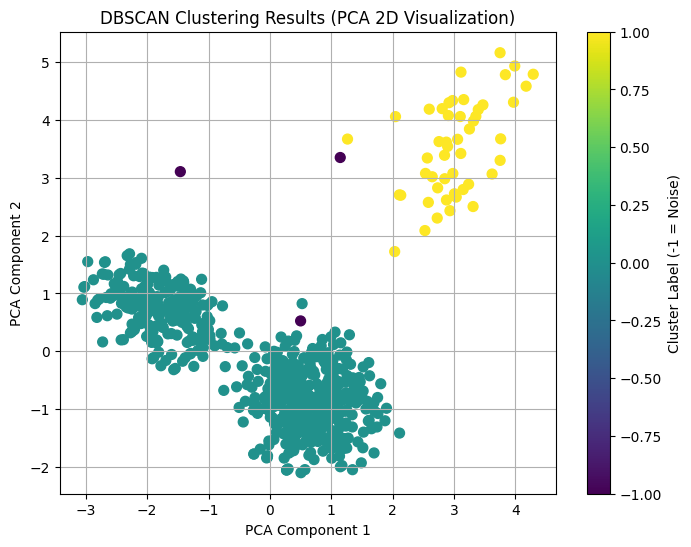

Suitable k (number of clusters excluding noise): 2


In [9]:
# Visualization with PCA (2D projection)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=50)
plt.title('DBSCAN Clustering Results (PCA 2D Visualization)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter, label='Cluster Label (-1 = Noise)')
plt.grid(True)
plt.show()

print(f'Suitable k (number of clusters excluding noise): {n_clusters_final}')